# Exp2: CIFAR-10 Image Classification Based On CNN

## Import Packages

In [2]:
from torch.utils.data import DataLoader
import torch.optim as optim 
import torch
import torchvision.datasets as dset
import torchvision.transforms as T
import json
from tools.visualization import visualize_single, visualize_multi
from modules.vgg import vgg11, vgg11_bn, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19, vgg19_bn
from modules.resnet import resnet18, resnet34, resnet50
import numpy as np
from modules.mymodel import ResNet9

%load_ext autoreload
%autoreload 2 

## Load CIFAR-10 Test Dataset

In [3]:
transform_test = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# load test dataset
dset_test = dset.CIFAR10('./datasets', train=False, download=True, transform=transform_test)
loader_test = DataLoader(dset_test, batch_size=128, num_workers=4)

Files already downloaded and verified


# Define a function to read json file for visualization.

In [4]:
def read_json(json_file, mode, select, epoch_num):
    x = []  # epoch number
    y = []  # evaluation indicator e.g. accuracy, loss
    
    with open(json_file, 'r') as f:
        for jsonstr in f.readlines():
            row_data = json.loads(jsonstr)
            if row_data['epoch'] > epoch_num:
                break
            if row_data['mode'] == mode:
                y_select = float(row_data[select])
                x_select = int(row_data['epoch'])
                x.append(x_select)
                y.append(y_select)
                
    return y, x

# Define the test function
Test the model on the test dataset and print the total accuracy and accuracy of each class.

In [5]:
def test(loader, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    class_correct = np.array([0 for _ in classes])
    class_total = np.array([0 for _ in classes])
    num_correct = 0
    num_samples = 0
    
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            batch_total = torch.bincount(y).cpu().numpy()
            batch_correct = torch.bincount(y[preds==y]).cpu().numpy()
            class_total += np.pad(batch_total, (0,10-len(batch_total)), 'constant', constant_values=(0, 0))
            class_correct += np.pad(batch_correct, (0,10-len(batch_correct)), 'constant', constant_values=(0, 0))
        
        print("Total Accuracy: %.4f%%" % (100 * float(num_correct) / num_samples))
        for i, value in enumerate(classes):
            print("%s: %.4f%%" % (classes[i], 100 * float(class_correct[i]) / class_total[i]))


# Simple ResNet

In [174]:
resnet9 = ResNet9()
resnet9.load_state_dict(torch.load('./work_dir/resnet/resnet9/epoch8.pth'))
test(loader_test, resnet9)

Total Accuracy: 90.5600%
plane: 91.8000%
car: 95.9000%
bird: 86.6000%
cat: 80.4000%
deer: 91.4000%
dog: 85.8000%
frog: 93.3000%
horse: 91.5000%
ship: 94.9000%
truck: 94.0000%


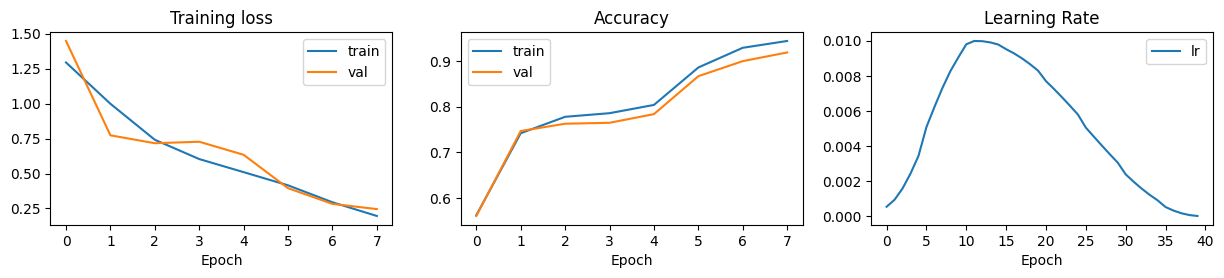

In [38]:
resnet9_train_loss, _ = read_json(json_file='./work_dir/resnet/resnet9/20230402_174749.json', mode='check', select='train_loss', epoch_num=8)
resnet9_val_loss, _ = read_json(json_file='./work_dir/resnet/resnet9/20230402_174749.json', mode='check', select='val_loss', epoch_num=8)
resnet9_train_acc, _ = read_json(json_file='./work_dir/resnet/resnet9/20230402_174749.json', mode='check', select='train_acc', epoch_num=8)
resnet9_val_acc, _ = read_json(json_file='./work_dir/resnet/resnet9/20230402_174749.json', mode='check', select='val_acc', epoch_num=8)
resnet9_bn_lr, _ = read_json(json_file='./work_dir/resnet/resnet9/20230402_174749.json', mode='train', select='lr', epoch_num=8)
visualize_single(resnet9_train_loss, resnet9_val_loss, resnet9_train_acc, resnet9_val_acc, resnet9_bn_lr)

# VGG
Use VGG to do classification on CIFAR-10. VGG is implemented in ./modules/vgg.py.
<br>
Totally, I train 4 different vggnets: vgg11_bn, vgg13_bn, vgg16_bn and vgg19_bn. 
<br>
Training logs are saved in ./work_dir/vgg and are transformed into json files.
<br>
The well-trained weights are saved in ./pth_file/vgg.
<br>
Compared with original VGG, here are some modifications I make:
- The kernel size of the average pooling layer is modified according to the input size of CIFAR-10 images and hence the fully connected layer following the average pooling layer is also modified.
- To save training time, I use transfer learning. To be specific, the features block in vggnet is pretrained on ImageNet and frozen during training, which means I only need to train the classifier.

### VGG11_bn
Test vgg11_bn.

In [150]:
vgg11_bn_ = vgg11_bn(pretrained=False, num_classes=10)
vgg11_bn_.load_state_dict(torch.load('./work_dir/vgg/vgg11_bn/epoch30.pth'))
test(loader_test, vgg11_bn_)

Total Accuracy: 90.4200%
plane: 93.0000%
car: 92.5000%
bird: 85.7000%
cat: 84.2000%
deer: 89.8000%
dog: 82.4000%
frog: 93.3000%
horse: 93.5000%
ship: 95.9000%
truck: 93.9000%


Read json files and visualize.

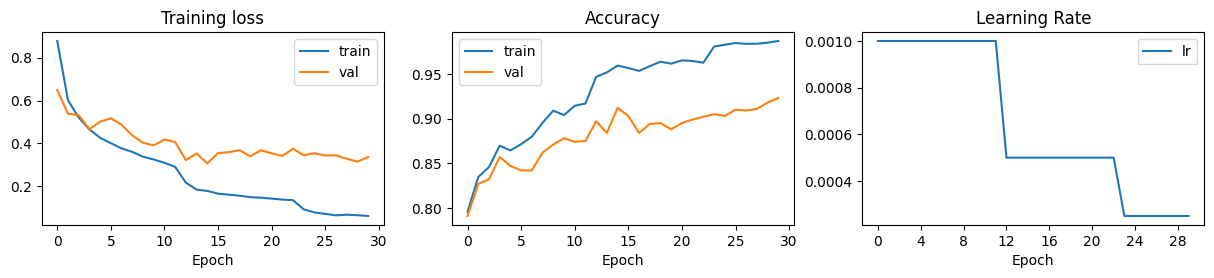

In [37]:
vgg11_bn_train_loss, _ = read_json(json_file='./work_dir/vgg/vgg11_bn/20230402_202107.json', mode='check', select='train_loss', epoch_num=30)
vgg11_bn_val_loss, _ = read_json(json_file='./work_dir/vgg/vgg11_bn/20230402_202107.json', mode='check', select='val_loss', epoch_num=30)
vgg11_bn_train_acc, _ = read_json(json_file='./work_dir/vgg/vgg11_bn/20230402_202107.json', mode='check', select='train_acc', epoch_num=30)
vgg11_bn_val_acc, _ = read_json(json_file='./work_dir/vgg/vgg11_bn/20230402_202107.json', mode='check', select='val_acc', epoch_num=30)
vgg11_bn_lr, _ = read_json(json_file='./work_dir/vgg/vgg11_bn/20230402_202107.json', mode='check', select='lr', epoch_num=30)
visualize_single(vgg11_bn_train_loss, vgg11_bn_val_loss, vgg11_bn_train_acc, vgg11_bn_val_acc, vgg11_bn_lr)

### VGG13_bn
Test vgg13_bn.

In [152]:
vgg13_bn_ = vgg13_bn(pretrained=False, num_classes=10)
vgg13_bn_.load_state_dict(torch.load('./work_dir/vgg/vgg13_bn/epoch29.pth'))
test(loader_test, vgg13_bn_)

Total Accuracy: 92.1800%
plane: 93.7000%
car: 96.1000%
bird: 91.1000%
cat: 79.5000%
deer: 93.6000%
dog: 87.3000%
frog: 94.7000%
horse: 95.6000%
ship: 95.4000%
truck: 94.8000%


Read json files and visualize.

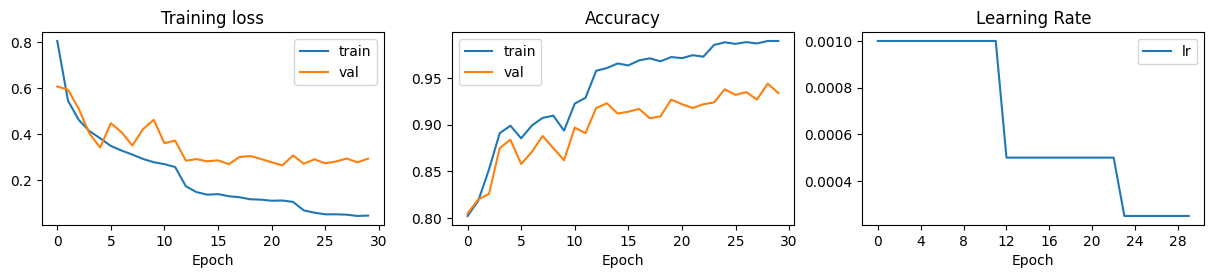

In [26]:
vgg13_bn_train_loss, _ = read_json(json_file='./work_dir/vgg/vgg13_bn/20230402_203017.json', mode='check', select='train_loss', epoch_num=30)
vgg13_bn_val_loss, _ = read_json(json_file='./work_dir/vgg/vgg13_bn/20230402_203017.json', mode='check', select='val_loss', epoch_num=30)
vgg13_bn_train_acc, _ = read_json(json_file='./work_dir/vgg/vgg13_bn/20230402_203017.json', mode='check', select='train_acc', epoch_num=30)
vgg13_bn_val_acc, _ = read_json(json_file='./work_dir/vgg/vgg13_bn/20230402_203017.json', mode='check', select='val_acc', epoch_num=30)
vgg13_bn_lr, _ = read_json(json_file='./work_dir/vgg/vgg13_bn/20230402_203017.json', mode='check', select='lr', epoch_num=30)
visualize_single(vgg13_bn_train_loss, vgg13_bn_val_loss, vgg13_bn_train_acc, vgg13_bn_val_acc, vgg13_bn_lr)

### VGG16_bn
Test vgg16_bn.

In [154]:
vgg16_bn_ = vgg16_bn(pretrained=False, num_classes=10)
vgg16_bn_.load_state_dict(torch.load('./work_dir/vgg/vgg16_bn/epoch26.pth'))
test(loader_test, vgg16_bn_)

Total Accuracy: 91.9100%
plane: 94.9000%
car: 96.7000%
bird: 90.4000%
cat: 81.7000%
deer: 95.1000%
dog: 86.7000%
frog: 93.6000%
horse: 92.5000%
ship: 92.5000%
truck: 95.0000%


Read json files and visualize.

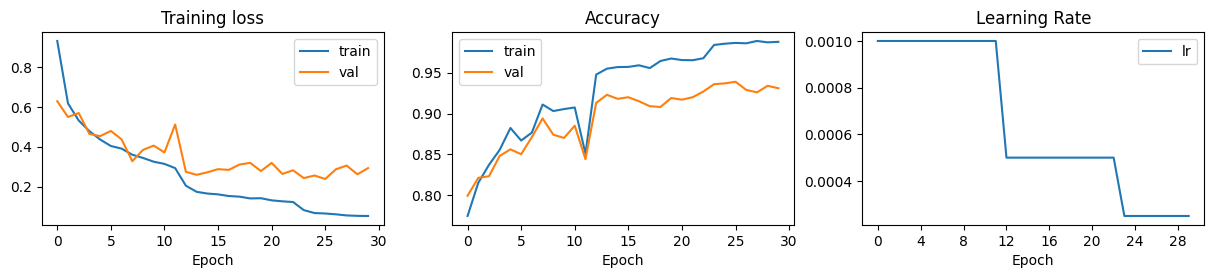

In [25]:
vgg16_bn_train_loss, _ = read_json(json_file='./work_dir/vgg/vgg16_bn/20230402_204426.json', mode='check', select='train_loss', epoch_num=30)
vgg16_bn_val_loss, _ = read_json(json_file='./work_dir/vgg/vgg16_bn/20230402_204426.json', mode='check', select='val_loss', epoch_num=30)
vgg16_bn_train_acc, _ = read_json(json_file='./work_dir/vgg/vgg16_bn/20230402_204426.json', mode='check', select='train_acc', epoch_num=30)
vgg16_bn_val_acc, _ = read_json(json_file='./work_dir/vgg/vgg16_bn/20230402_204426.json', mode='check', select='val_acc', epoch_num=30)
vgg16_bn_lr, _ = read_json(json_file='./work_dir/vgg/vgg16_bn/20230402_204426.json', mode='check', select='lr', epoch_num=30)
visualize_single(vgg16_bn_train_loss, vgg16_bn_val_loss, vgg16_bn_train_acc, vgg16_bn_val_acc, vgg16_bn_lr)

### VGG19_bn
Test vgg19_bn.

In [7]:
vgg19_bn_ = vgg19_bn(pretrained=False, num_classes=10)
vgg19_bn_.load_state_dict(torch.load('./work_dir/vgg/vgg19_bn/epoch25.pth'))
test(loader_test, vgg19_bn_)

Total Accuracy: 91.8100%
plane: 93.1000%
car: 97.2000%
bird: 88.4000%
cat: 85.4000%
deer: 92.3000%
dog: 87.1000%
frog: 91.4000%
horse: 94.0000%
ship: 95.0000%
truck: 94.2000%


Read json files and visualize.

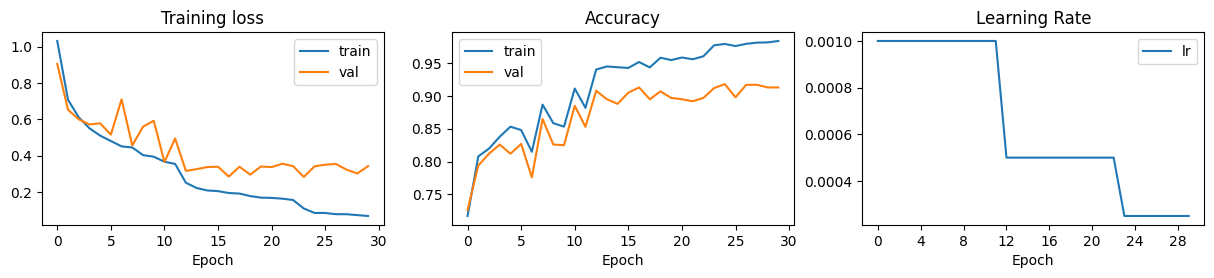

In [24]:
vgg19_bn_train_loss, _ = read_json(json_file='./work_dir/vgg/vgg19_bn/20230403_085206.json', mode='check', select='train_loss', epoch_num=30)
vgg19_bn_val_loss, _ = read_json(json_file='./work_dir/vgg/vgg19_bn/20230403_085206.json', mode='check', select='val_loss', epoch_num=30)
vgg19_bn_train_acc, _ = read_json(json_file='./work_dir/vgg/vgg19_bn/20230403_085206.json', mode='check', select='train_acc', epoch_num=30)
vgg19_bn_val_acc, _ = read_json(json_file='./work_dir/vgg/vgg19_bn/20230403_085206.json', mode='check', select='val_acc', epoch_num=30)
vgg19_bn_lr, _ = read_json(json_file='./work_dir/vgg/vgg19_bn/20230403_085206.json', mode='check', select='lr', epoch_num=30)
visualize_single(vgg19_bn_train_loss, vgg19_bn_val_loss, vgg19_bn_train_acc, vgg19_bn_val_acc, vgg19_bn_lr)

### Compare VggNets of different layer numbers

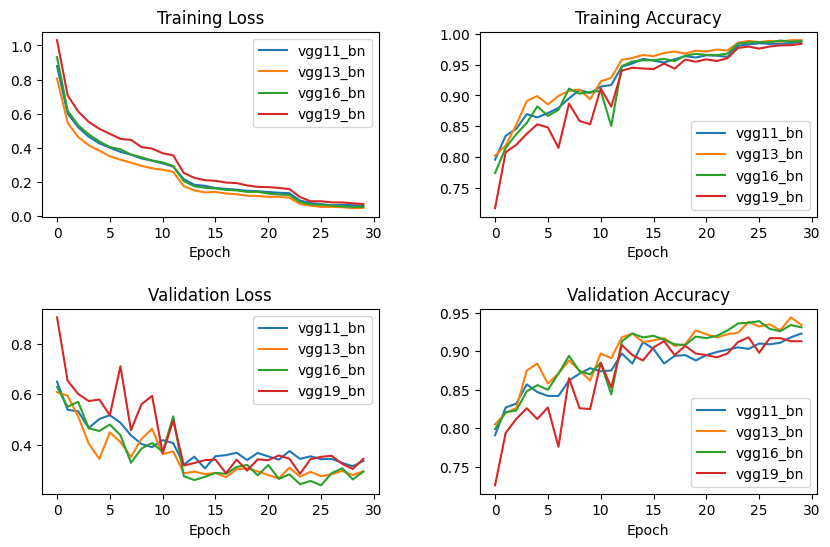

In [36]:
names = ['vgg11_bn', 'vgg13_bn', 'vgg16_bn', 'vgg19_bn']
train_loss = [vgg11_bn_train_loss, vgg13_bn_train_loss, vgg16_bn_train_loss, vgg19_bn_train_loss]
val_loss = [vgg11_bn_val_loss, vgg13_bn_val_loss, vgg16_bn_val_loss, vgg19_bn_val_loss]
train_acc = [vgg11_bn_train_acc, vgg13_bn_train_acc, vgg16_bn_train_acc, vgg19_bn_train_acc]
val_acc = [vgg11_bn_val_acc, vgg13_bn_val_acc, vgg16_bn_val_acc,vgg19_bn_val_acc]
visualize_multi(names, train_loss, train_acc, val_loss, val_acc)

# Resnet
Use Resnet to do classification on CIFAR-10. Resnet is implemented in ./modules/resnet.py.
<br>
Totally, I train 3 different resnets: resnet18, resnet34 and resnet50. 
<br>
Training logs and well-trained weights are saved in ./work_dir/resnet and logs are transformed into json files.
<br>
Compared with original ResNet, here are some modifications I make:
- The kernel size, stride and padding of the first conv layer, the kernel size and stride of the first maxpool layer are modified according to the input size of CIFAR-10 images.
- To save training time, I use transfer learning. To be specific, all residual blocks are pretrained on ImageNet and frozen during training.

### ResNet18
Test resnet18.

In [45]:
resnet18_ = resnet18(pretrained=False, num_classes=10)
resnet18_.load_state_dict(torch.load('./work_dir/resnet/resnet18/epoch24.pth'))
test(loader_test, resnet18_)

Total Accuracy: 90.7600%
plane: 93.2000%
car: 95.2000%
bird: 84.5000%
cat: 76.3000%
deer: 91.8000%
dog: 89.6000%
frog: 93.5000%
horse: 93.9000%
ship: 95.6000%
truck: 94.0000%


Read json files and visualize.

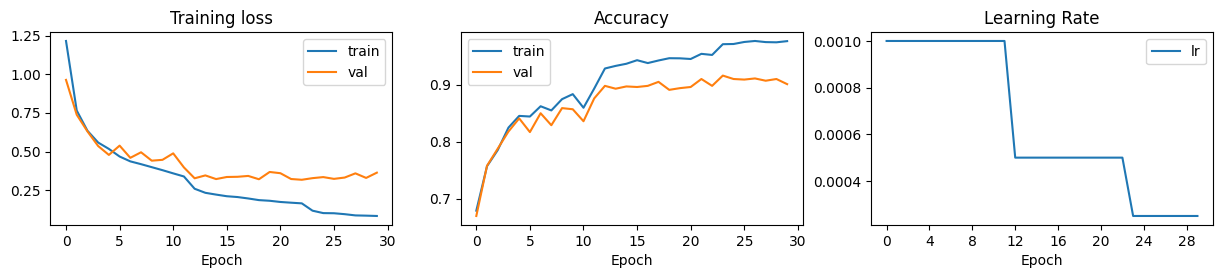

In [39]:
resnet18_train_loss, _ = read_json(json_file='./work_dir/resnet/resnet18/20230402_174227.json', mode='check', select='train_loss', epoch_num=30)
resnet18_val_loss, _ = read_json(json_file='./work_dir/resnet/resnet18/20230402_174227.json', mode='check', select='val_loss', epoch_num=30)
resnet18_train_acc, _ = read_json(json_file='./work_dir/resnet/resnet18/20230402_174227.json', mode='check', select='train_acc', epoch_num=30)
resnet18_val_acc, _ = read_json(json_file='./work_dir/resnet/resnet18/20230402_174227.json', mode='check', select='val_acc', epoch_num=30)
resnet18_lr, _ = read_json(json_file='./work_dir/resnet/resnet18/20230402_174227.json', mode='check', select='lr', epoch_num=30)
visualize_single(resnet18_train_loss, resnet18_val_loss, resnet18_train_acc, resnet18_val_acc, resnet18_lr)

### ResNet34
Test resnet34.

In [46]:
resnet34_ = resnet34(pretrained=False, num_classes=10)
resnet34_.load_state_dict(torch.load('./work_dir/resnet/resnet34/epoch29.pth'))
test(loader_test, resnet34_)

Total Accuracy: 90.1300%
plane: 91.9000%
car: 95.8000%
bird: 84.4000%
cat: 77.5000%
deer: 93.3000%
dog: 83.2000%
frog: 92.6000%
horse: 94.2000%
ship: 95.0000%
truck: 93.4000%


Read json files and visualize.

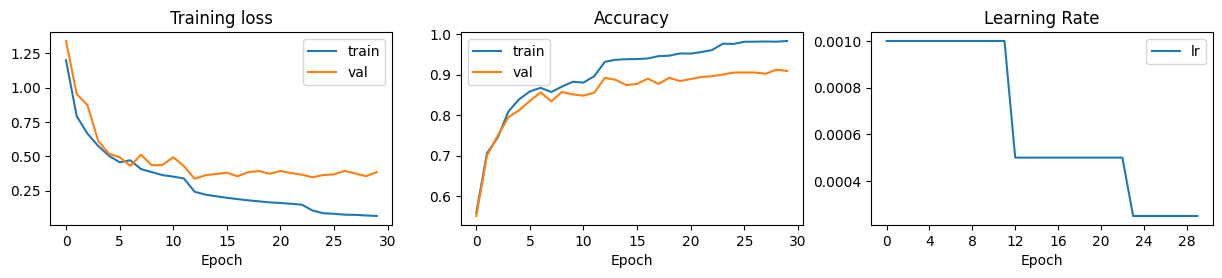

In [40]:
resnet34_train_loss, _ = read_json(json_file='./work_dir/resnet/resnet34/20230402_174229.json', mode='check', select='train_loss', epoch_num=30)
resnet34_val_loss, _ = read_json(json_file='./work_dir/resnet/resnet34/20230402_174229.json', mode='check', select='val_loss', epoch_num=30)
resnet34_train_acc, _ = read_json(json_file='./work_dir/resnet/resnet34/20230402_174229.json', mode='check', select='train_acc', epoch_num=30)
resnet34_val_acc, _ = read_json(json_file='./work_dir/resnet/resnet34/20230402_174229.json', mode='check', select='val_acc', epoch_num=30)
resnet34_lr, _ = read_json(json_file='./work_dir/resnet/resnet34/20230402_174229.json', mode='check', select='lr', epoch_num=30)
visualize_single(resnet34_train_loss, resnet34_val_loss, resnet34_train_acc, resnet34_val_acc, resnet34_lr)

### ResNet50
Test resnet50.

In [149]:
resnet50_ = resnet50(pretrained=False, num_classes=10)
resnet50_.load_state_dict(torch.load('./work_dir/resnet/resnet50/epoch24.pth'))
test(loader_test, resnet50_)

Total Accuracy: 91.4100%
plane: 93.2000%
car: 95.5000%
bird: 88.2000%
cat: 80.5000%
deer: 92.3000%
dog: 85.5000%
frog: 96.2000%
horse: 92.7000%
ship: 95.6000%
truck: 94.4000%


Read json files and visualize.

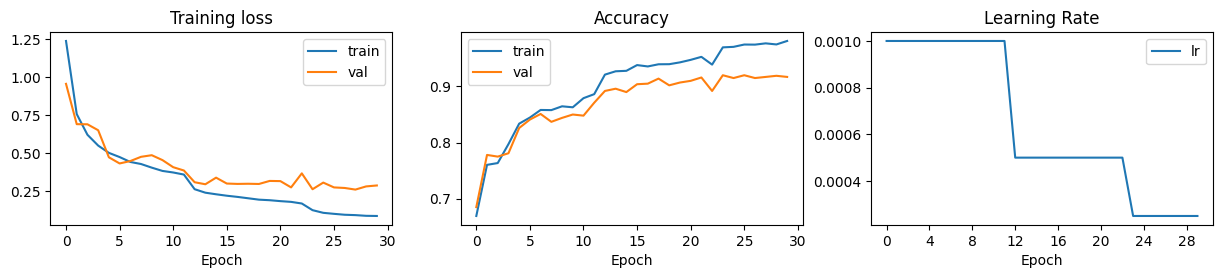

In [41]:
resnet50_train_loss, _ = read_json(json_file='./work_dir/resnet/resnet50/20230402_174231.json', mode='check', select='train_loss', epoch_num=30)
resnet50_val_loss, _ = read_json(json_file='./work_dir/resnet/resnet50/20230402_174231.json', mode='check', select='val_loss', epoch_num=30)
resnet50_train_acc, _ = read_json(json_file='./work_dir/resnet/resnet50/20230402_174231.json', mode='check', select='train_acc', epoch_num=30)
resnet50_val_acc, _ = read_json(json_file='./work_dir/resnet/resnet50/20230402_174231.json', mode='check', select='val_acc', epoch_num=30)
resnet50_lr, _ = read_json(json_file='./work_dir/resnet/resnet50/20230402_174231.json', mode='check', select='lr', epoch_num=30)
visualize_single(resnet50_train_loss, resnet50_val_loss, resnet50_train_acc, resnet50_val_acc, resnet50_lr)

### Compare ResNets of different layer numbers

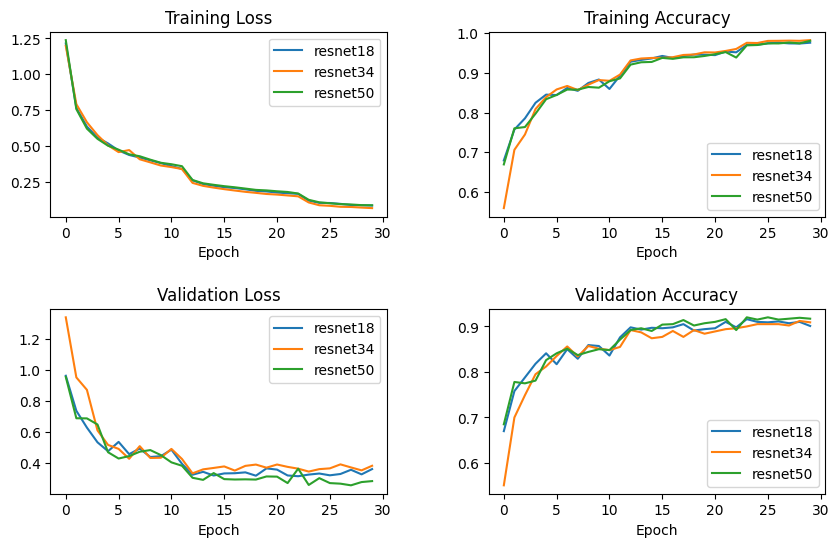

In [47]:
names = ['resnet18', 'resnet34', 'resnet50']
train_loss = [resnet18_train_loss, resnet34_train_loss, resnet50_train_loss]
train_acc = [resnet18_train_acc, resnet34_train_acc, resnet50_train_acc]
val_loss = [resnet18_val_loss, resnet34_val_loss, resnet50_val_loss]
val_acc = [resnet18_val_acc, resnet34_val_acc,resnet50_val_acc]
visualize_multi(names, train_loss, train_acc, val_loss, val_acc)